<a href="https://colab.research.google.com/github/Kannakattisanjana/Detection_of_malicious_traffic_in_DoH/blob/main/doh(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
import sklearn.externals
import joblib 
import IPython.display 
import sklearn.tree 
import pydotplus
import os
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.preprocessing import StandardScaler # Import for standard scaling of the data
from sklearn.preprocessing import MinMaxScaler 

### dataset Details
The dataset used for this research is the CIRA-CIC-DoHBrw-2020 df developed by the Canadian Institute of Cybersecurity.
This df can be found on : ```https://www.unb.ca/cic/dfs/dohbrw-2020.html```

The CIRA-CIC-DoHBrw-2020 df provides 10 days of network traffic from Monday, December 10 to Thursday December 20, 2019. The df consists of 371,836 labelled network flows consisting of 34 features (MontazeriShatoori, et al., 2020).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# importing the df and outputting the first 5 samples in the df
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/data1.csv")
print(df.shape)
df.head(5)

(269643, 36)


,Unnamed: 0,SourceIP,DestinationIP,SourcePort,DestinationPort,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH
0,0,192.168.20.205,8.8.4.4,41018,443,3/25/20 4:40,120.731389,46446,384.705257,85465,...,0.622162,0.000070,0.008369,0.011880,0.015244,0.015221,-1.205904,-0.399220,0.704513,DNSCAT2
1,1,8.8.4.4,192.168.20.205,443,41018,3/25/20 4:42,120.052751,470548,3919.510349,227661,...,0.331509,0.023756,0.154130,0.037553,0.000049,0.000039,0.729988,0.243394,4.104293,DNSCAT2
2,2,8.8.4.4,192.168.20.205,443,41018,3/25/20 4:44,120.034398,747083,6223.907584,355181,...,0.579348,0.000276,0.016611,0.011986,0.000048,0.000030,2.156008,0.719753,1.385888,DNSCAT2
3,3,8.8.4.4,192.168.20.205,443,41018,3/25/20 4:46,120.004804,745382,6211.268009,354606,...,0.580188,0.000271,0.016473,0.011724,0.000049,0.000031,2.126128,0.709802,1.405118,DNSCAT2
4,4,8.8.4.4,192.168.20.205,443,41018,3/25/20 4:48,120.025620,749888,6247.732776,356531,...,0.578922,0.000271,0.016458,0.011725,0.000048,0.000031,2.128463,0.710521,1.403698,DNSCAT2


In [ ]:
df.loc[100000,:'DoH']

Unnamed: 0                                         64230
SourceIP                                  192.168.20.210
DestinationIP                                   9.9.9.11
SourcePort                                         38812
DestinationPort                                      443
TimeStamp                                  3/31/20 16:55
Duration                                       34.279124
FlowBytesSent                                       1807
FlowSentRate                                   52.714299
FlowBytesReceived                                   4829
FlowReceivedRate                              140.872911
PacketLengthVariance                         145617.3151
PacketLengthStandardDeviation                 381.598369
PacketLengthMean                              228.827586
PacketLengthMedian                                  76.0
PacketLengthMode                                      68
PacketLengthSkewFromMedian                       1.20148
PacketLengthSkewFromMode       

In [ ]:
df.loc[0,:'DoH']

Unnamed: 0                                             0
SourceIP                                  192.168.20.205
DestinationIP                                    8.8.4.4
SourcePort                                         41018
DestinationPort                                      443
TimeStamp                                   3/25/20 4:40
Duration                                      120.731389
FlowBytesSent                                      46446
FlowSentRate                                  384.705257
FlowBytesReceived                                  85465
FlowReceivedRate                              707.893786
PacketLengthVariance                         5668.351021
PacketLengthStandardDeviation                  75.288452
PacketLengthMean                               117.04614
PacketLengthMedian                                 107.0
PacketLengthMode                                      68
PacketLengthSkewFromMedian                      0.400306
PacketLengthSkewFromMode       

In [ ]:
# Analyzing the target class to see how balanced or unbalanced the dataset is.
print(df.groupby('DoH').size())

DoH
Benign      19807
DNS2TCP    167486
DNSCAT2     35770
IODINE      46580
dtype: int64


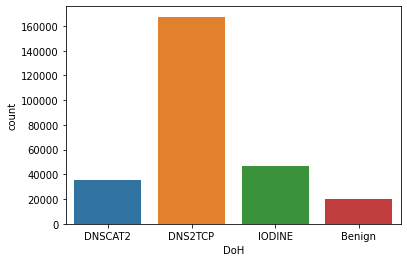

In [ ]:
sns.countplot(x='DoH', data=df);

In [ ]:
#checking for the null values and removong.
null = df.isnull()
# print(df.isnull().any().any())
# print(null.sum())
df['ResponseTimeTimeMedian'] = df['ResponseTimeTimeMedian'].fillna(0)
df['ResponseTimeTimeSkewFromMedian'] = df['ResponseTimeTimeSkewFromMedian'].fillna(0)
null = df.isnull()
# print("New: ", df.isnull().any().any())

# print("New: ", null.sum())

### Data Preparation
In this phase, The removal of features with insignificant values was carried out . These features were, Source IP, Destination IP, Packet Time Mode and Timestamp. You may ask, why were these features chosen. Well, Source IP and Destination IP were dropped from the df because in a practical sense, numerous applications exist that randomly generate IP addresses making it not a good feature in training an anomaly detection system. So instead of targeting those features, the machine learning model was trained using data that replicates the behavior of DNS tunneling on the DoH protocol. Timestamp on the other hand was removed because it was observed that it had a high correlation with the target variable. To prevent data leakage, timestamp was removed as a feature. 

In [ ]:
# df.head()

In [ ]:
df = df.drop(labels = ['Unnamed: 0','SourceIP','DestinationIP','SourcePort','DestinationPort'], axis = 1)



In [ ]:
# df.columns


In [ ]:
# df.info(5)

In [ ]:
df[df.isnull().any(axis=1)]

,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH


In [ ]:
# removal of data samples that contained Na or duplicates
df = df.dropna()
df = df.drop_duplicates()

In [ ]:

"""
#Converting object variables to category var
columns = ["SourceIP", "DestinationIP", "Label"]

for col in columns:
    df[col] = df[col].astype('category')"""



'\n#Converting object variables to category var\ncolumns = ["SourceIP", "DestinationIP", "Label"]\n\nfor col in columns:\n    df[col] = df[col].astype(\'category\')'

In [ ]:
df.info(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 269617 entries, 0 to 269642
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   TimeStamp                               269617 non-null  object 
 1   Duration                                269617 non-null  float64
 2   FlowBytesSent                           269617 non-null  int64  
 3   FlowSentRate                            269617 non-null  float64
 4   FlowBytesReceived                       269617 non-null  int64  
 5   FlowReceivedRate                        269617 non-null  float64
 6   PacketLengthVariance                    269617 non-null  float64
 7   PacketLengthStandardDeviation           269617 non-null  float64
 8   PacketLengthMean                        269617 non-null  float64
 9   PacketLengthMedian                      269617 non-null  float64
 10  PacketLengthMode                        2696

In [ ]:
df_prep = df.copy()

In [ ]:
df_prep.head()

,TimeStamp,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,...,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation,DoH
0,3/25/20 4:40,120.731389,46446,384.705257,85465,707.893786,5668.351021,75.288452,117.046140,107.0,...,0.622162,0.000070,0.008369,0.011880,0.015244,0.015221,-1.205904,-0.399220,0.704513,DNSCAT2
1,3/25/20 4:42,120.052751,470548,3919.510349,227661,1896.341384,8083.727768,89.909553,128.347243,107.0,...,0.331509,0.023756,0.154130,0.037553,0.000049,0.000039,0.729988,0.243394,4.104293,DNSCAT2
2,3/25/20 4:44,120.034398,747083,6223.907584,355181,2958.993471,8571.035514,92.579887,129.434476,107.0,...,0.579348,0.000276,0.016611,0.011986,0.000048,0.000030,2.156008,0.719753,1.385888,DNSCAT2
3,3/25/20 4:46,120.004804,745382,6211.268009,354606,2954.931704,8553.829399,92.486915,129.227913,107.0,...,0.580188,0.000271,0.016473,0.011724,0.000049,0.000031,2.126128,0.709802,1.405118,DNSCAT2
4,3/25/20 4:48,120.025620,749888,6247.732776,356531,2970.457474,8529.864415,92.357265,129.209272,107.0,...,0.578922,0.000271,0.016458,0.011725,0.000048,0.000031,2.128463,0.710521,1.403698,DNSCAT2


In [ ]:
cor = df_prep.corr()
cor

,Duration,FlowBytesSent,FlowSentRate,FlowBytesReceived,FlowReceivedRate,PacketLengthVariance,PacketLengthStandardDeviation,PacketLengthMean,PacketLengthMedian,PacketLengthMode,...,PacketTimeSkewFromMode,PacketTimeCoefficientofVariation,ResponseTimeTimeVariance,ResponseTimeTimeStandardDeviation,ResponseTimeTimeMean,ResponseTimeTimeMedian,ResponseTimeTimeMode,ResponseTimeTimeSkewFromMedian,ResponseTimeTimeSkewFromMode,ResponseTimeTimeCoefficientofVariation
Duration,1.000000,0.392672,-0.048074,0.399255,-0.068030,-0.557018,-0.625178,-0.508014,0.385955,0.002809,...,0.256448,-0.440806,0.096727,0.115503,0.210683,0.213078,0.160796,0.281682,-0.024306,0.204084
FlowBytesSent,0.392672,1.000000,-0.004255,0.805911,-0.007311,-0.258516,-0.292675,-0.178798,0.284195,0.025139,...,0.050139,-0.306957,-0.060071,-0.069529,-0.079938,-0.077031,-0.054356,0.174953,-0.090554,0.444504
FlowSentRate,-0.048074,-0.004255,1.000000,-0.007317,0.953712,-0.034404,-0.053647,-0.058920,-0.009116,-0.029763,...,0.000265,-0.013917,-0.008515,-0.011706,-0.011575,-0.010773,-0.007616,-0.196108,-0.280239,-0.020763
FlowBytesReceived,0.399255,0.805911,-0.007317,1.000000,-0.005032,-0.261428,-0.290058,-0.146282,0.381202,0.045745,...,0.080420,-0.314640,-0.064108,-0.077903,-0.086330,-0.081925,-0.057701,0.125353,-0.088717,0.238354
FlowReceivedRate,-0.068030,-0.007311,0.953712,-0.005032,1.000000,-0.010049,-0.034916,-0.041803,-0.017183,-0.028947,...,0.018649,-0.031585,-0.012427,-0.016887,-0.016838,-0.015675,-0.011130,-0.202727,-0.281866,-0.026123
PacketLengthVariance,-0.557018,-0.258516,-0.034404,-0.261428,-0.010049,1.000000,0.933743,0.788465,-0.254532,-0.020388,...,-0.129609,0.257201,-0.101684,-0.098434,-0.193072,-0.203314,-0.146105,-0.041234,0.235022,-0.142276
PacketLengthStandardDeviation,-0.625178,-0.292675,-0.053647,-0.290058,-0.034916,0.933743,1.000000,0.897319,-0.236944,-0.031736,...,-0.252459,0.441640,-0.171794,-0.176502,-0.315637,-0.324385,-0.236005,-0.046449,0.299000,-0.140213
PacketLengthMean,-0.508014,-0.178798,-0.058920,-0.146282,-0.041803,0.788465,0.897319,1.000000,0.052530,-0.006416,...,-0.167394,0.333158,-0.217891,-0.224657,-0.387864,-0.395188,-0.289436,0.069198,0.249817,-0.084909
PacketLengthMedian,0.385955,0.284195,-0.009116,0.381202,-0.017183,-0.254532,-0.236944,0.052530,1.000000,0.107300,...,0.182522,-0.183620,-0.107661,-0.097124,-0.167591,-0.167337,-0.123852,0.241519,-0.141074,0.168372
PacketLengthMode,0.002809,0.025139,-0.029763,0.045745,-0.028947,-0.020388,-0.031736,-0.006416,0.107300,1.000000,...,-0.063339,0.001596,-0.045867,-0.041899,-0.112839,-0.101499,-0.107077,-0.098600,-0.173748,0.007939


In [ ]:
#sns.boxplot(x=df_prep['SourcePort'])

In [ ]:
# plt.figure(figsize=(15,10))
# sns.heatmap(data=cor, annot=True)

Text(0.5, 1.0, 'DNS2TCP')

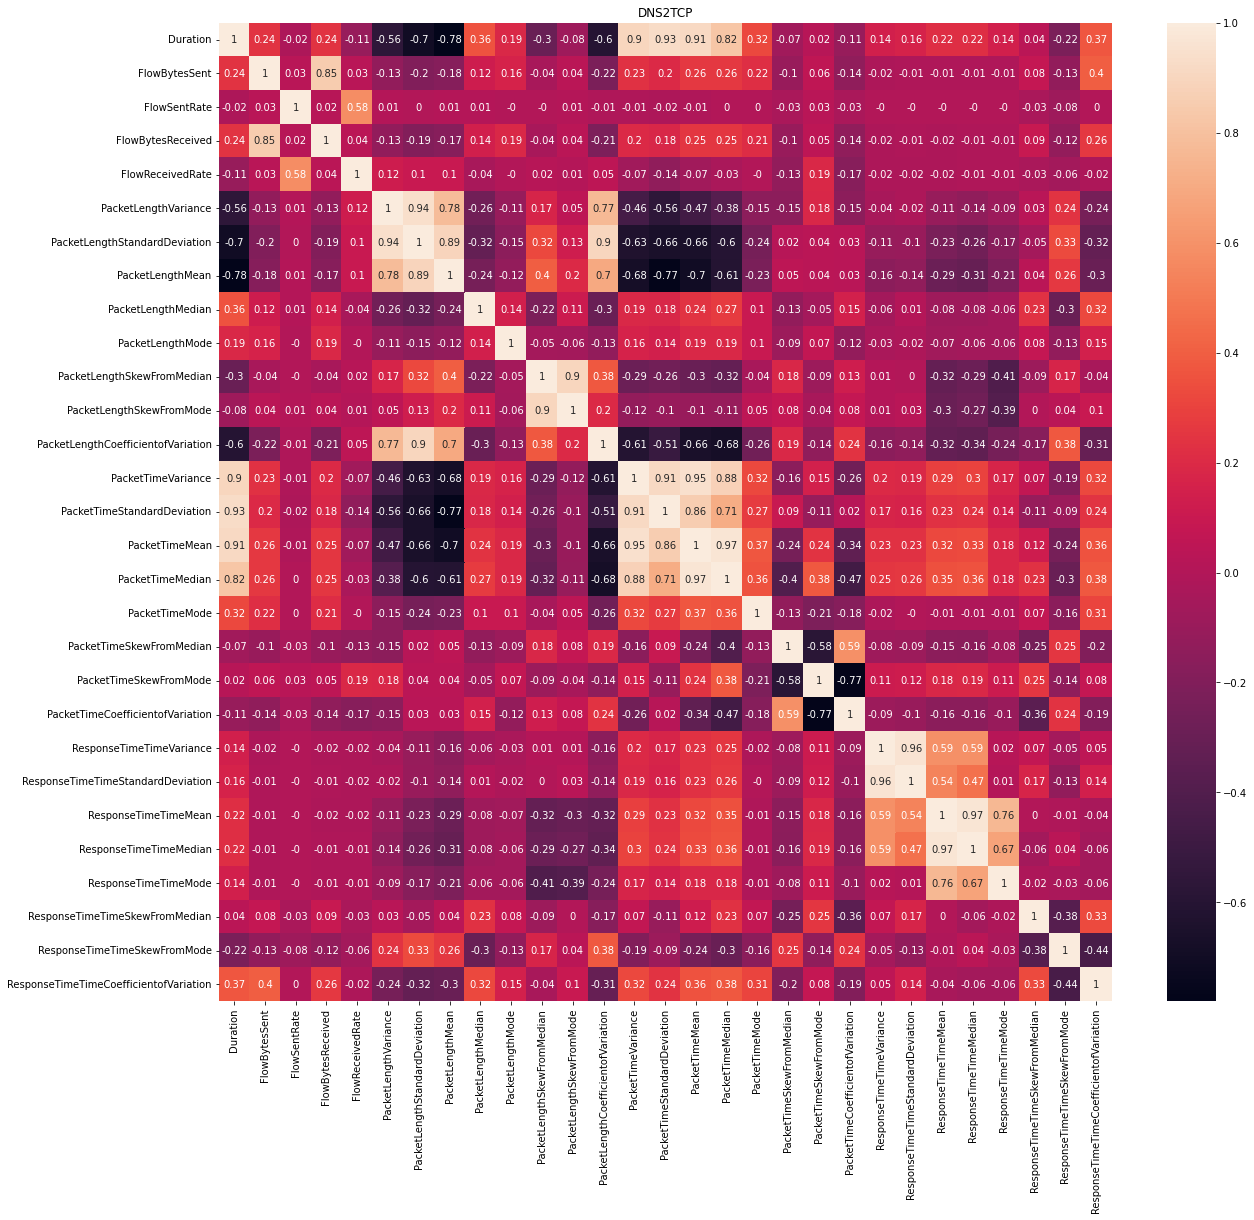

In [ ]:
hep = df_prep.loc[df_prep.DoH=="DNS2TCP"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("DNS2TCP")

Text(0.5, 1.0, 'Malicious')

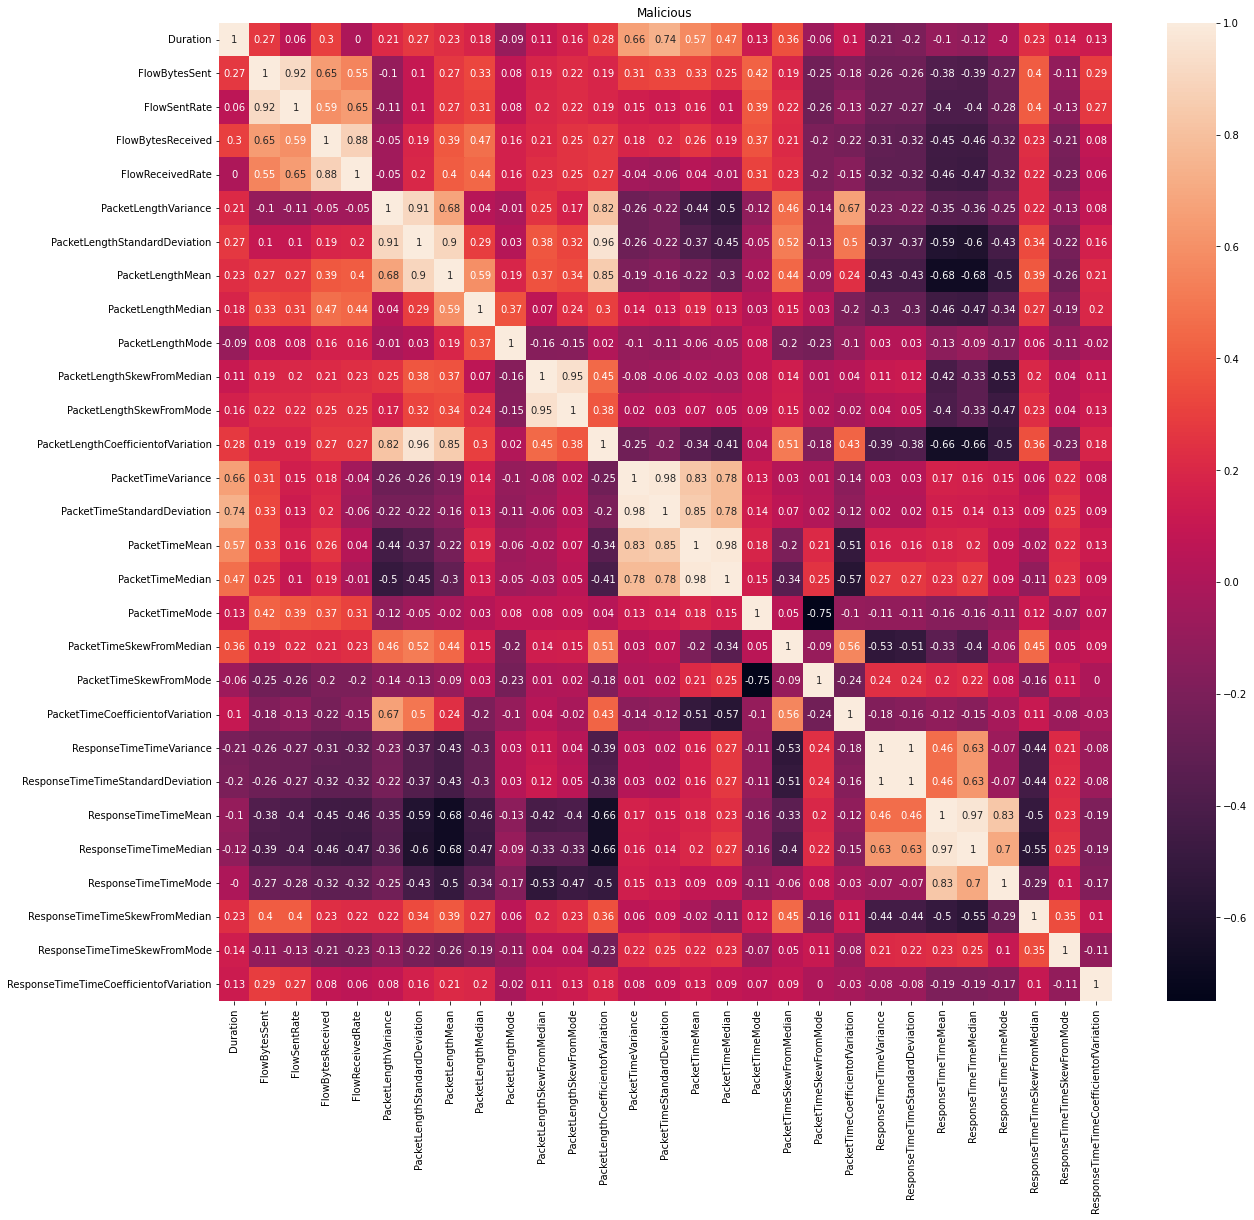

In [ ]:
hep = df_prep.loc[df_prep.DoH=="DNSCAT2"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("Malicious")

Text(0.5, 1.0, 'Malicious')

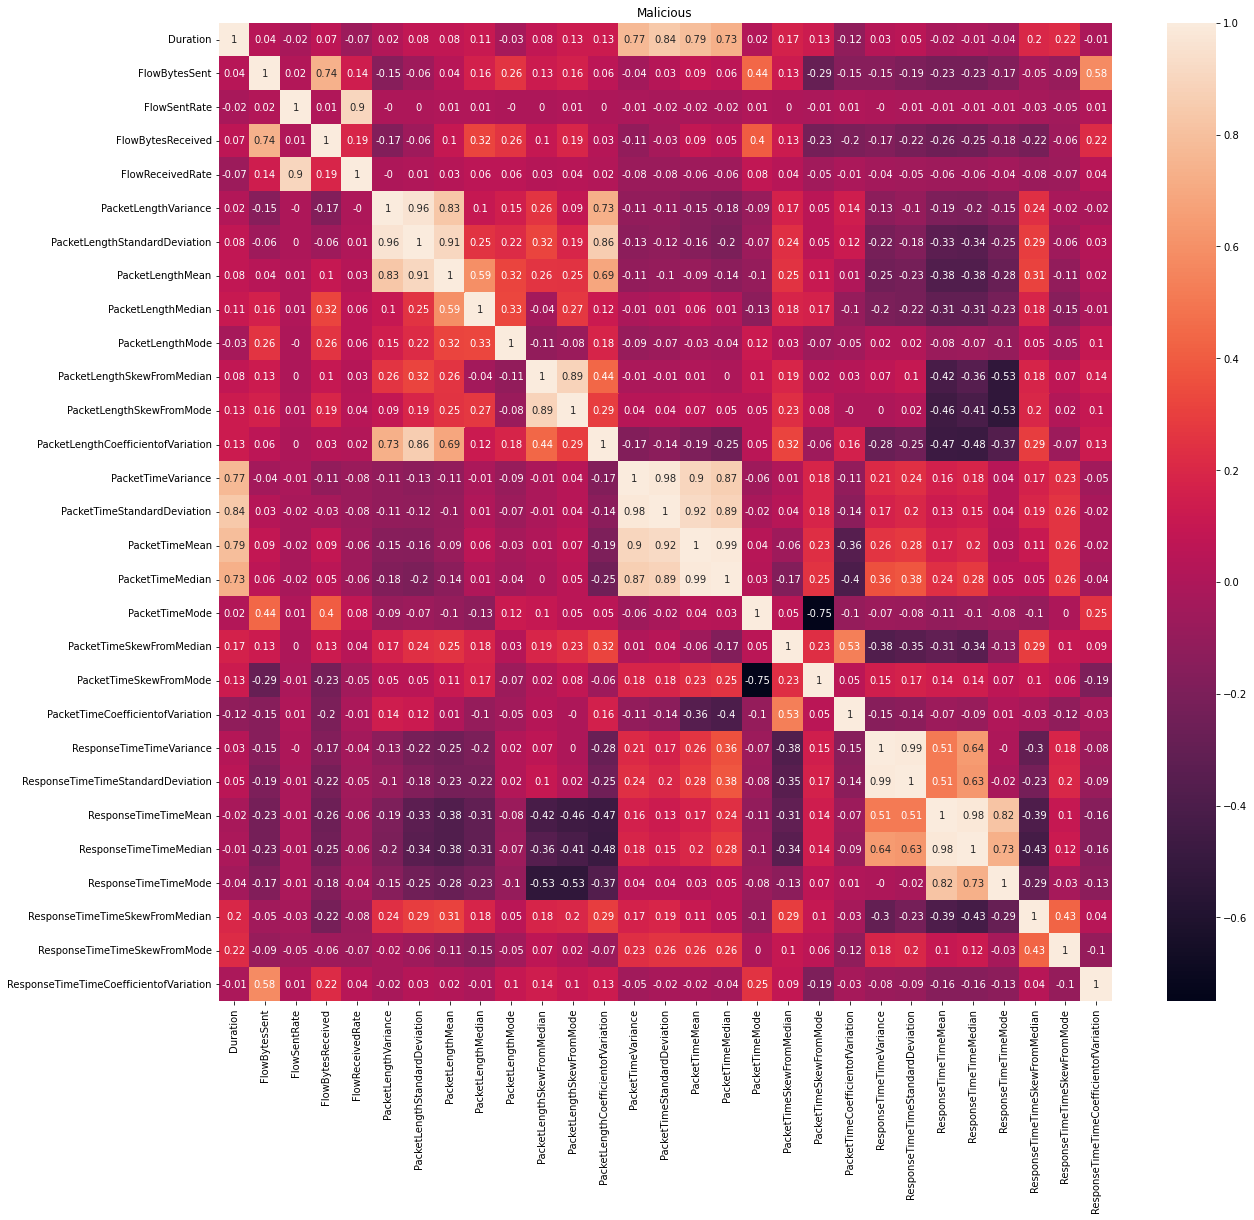

In [ ]:
hep = df_prep.loc[df_prep.DoH=="IODINE"]

corr_mat_hep = hep.corr().round(2)
corr_mat_hep

plt.figure(figsize=(20,18))
plot = sns.heatmap(hep.corr().round(2), annot= True)
plot.set_title("Malicious")

In [ ]:
# split dataset in features and target variable

# Features
X = df_prep.drop(columns=["DoH"])

# Target variable
y = df_prep['DoH']

In [ ]:
# import sklearn packages for data treatments
from sklearn.model_selection import train_test_split # Import train_test_split function

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

In [ ]:
X_train.shape

(188731, 30)

In [ ]:
y_train.shape

(188731,)

In [ ]:
X_test.shape

(80886, 30)

In [ ]:
y_test.shape

(80886,)

In [ ]:
X_train_temp = X_train.copy()
X_train_temp = X_train_temp.drop(['TimeStamp'],axis=1)
X_test_temp = X_test.copy()
X_test_temp = X_test_temp.drop(['TimeStamp'],axis=1)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


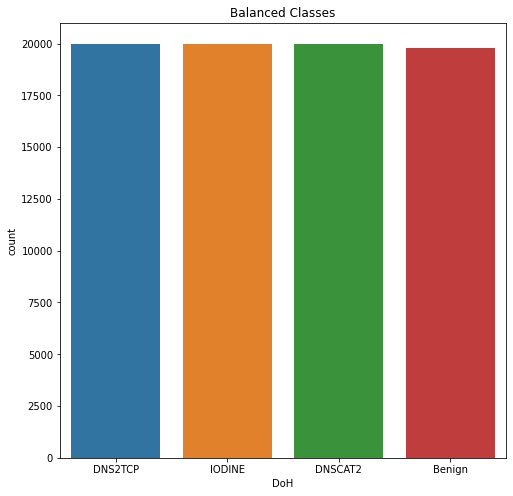

In [ ]:
shuffled_df = df_prep.drop(['TimeStamp'],axis=1).sample(frac=1,random_state=4)

Dns2tcp_df = shuffled_df.loc[shuffled_df['DoH'] == 'DNS2TCP'].sample(n=20000,random_state=30)
IODINE_df = shuffled_df.loc[shuffled_df['DoH'] == 'IODINE'].sample(n=20000,random_state=40)
shuffled_df.shape
DNSCAT2_df = shuffled_df.loc[shuffled_df['DoH'] == 'DNSCAT2'].sample(n=20000,random_state=40)
Benign_df = shuffled_df.loc[shuffled_df['DoH'] == 'Benign']

normalized_df = pd.concat([Dns2tcp_df, IODINE_df, DNSCAT2_df,Benign_df])

plt.figure(figsize=(8, 8))
sns.countplot('DoH', data=normalized_df)
plt.title('Balanced Classes')
plt.show()

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import StandardScaler # Import for standard scaling of the data
from sklearn.preprocessing import MinMaxScaler # Import for standard scaling of the data

# standard scale data
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train_temp)
X_test_scaled = ss.transform(X_test_temp)

# tested MinMaxScaler as KNN historically does better with MinMax
mm = MinMaxScaler()
X_train_mm_scaled = ss.fit_transform(X_train_temp)
X_test_mm_scaled = ss.transform(X_test_temp)

# program to run multilple models though sklearn 
# Default settings output accuracy and classification report
# compares accuracy for scaled and unscaled data
def run_models(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame):
    
    models = [          
          ('Random Forest', RandomForestClassifier(random_state=2020)),
          ('Decision Tree', DecisionTreeClassifier())
        ]  
    
    for name, model in models:        
        # unscaled data
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # scaled data
        clf_scaled = model.fit(X_train_scaled, y_train)
        y_pred_scaled = clf_scaled.predict(X_test_scaled)
        
        # mm scaled data
        clf_mm_scaled = model.fit(X_train_mm_scaled, y_train)
        y_pred_mm_scaled = clf_scaled.predict(X_test_mm_scaled)
        
        # accuracy scores
        accuracy = round(metrics.accuracy_score(y_test, y_pred),5)
        scaled_accuracy = round(metrics.accuracy_score(y_test, y_pred_scaled),5)
        scaled_mm_accuracy = round(metrics.accuracy_score(y_test, y_pred_mm_scaled),5)
        
        # output
        print(name + ':')        
        print("---------------------------------------------------------------")      
        print("Accuracy:", accuracy)
        print("Accuracy w/Scaled Data (ss):", scaled_accuracy)
        print("Accuracy w/Scaled Data (mm):", scaled_mm_accuracy)
        if (accuracy > scaled_accuracy) and (accuracy > scaled_mm_accuracy):
            print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred))      
            print("                            -----------------------------------               \n")      
        elif (scaled_accuracy > scaled_mm_accuracy):
            print("\nClassification Report (ss):\n", metrics.classification_report(y_test, y_pred_scaled))      
            print("                            -----------------------------------               \n")     
        else:            
            print("\nClassification Report (mm):\n", metrics.classification_report(y_test, y_pred_mm_scaled))      
            print("                            -----------------------------------               \n")     

In [ ]:
run_models(X_train_temp, y_train, X_test_temp, y_test)

Random Forest:
---------------------------------------------------------------
Accuracy: 0.97252
Accuracy w/Scaled Data (ss): 0.97253
Accuracy w/Scaled Data (mm): 0.97253

Classification Report (mm):
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00      5995
     DNS2TCP       0.99      0.99      0.99     50146
     DNSCAT2       0.92      0.92      0.92     10868
      IODINE       0.93      0.94      0.94     13877

    accuracy                           0.97     80886
   macro avg       0.96      0.96      0.96     80886
weighted avg       0.97      0.97      0.97     80886

                            -----------------------------------               

Decision Tree:
---------------------------------------------------------------
Accuracy: 0.96358
Accuracy w/Scaled Data (ss): 0.963
Accuracy w/Scaled Data (mm): 0.96329

Classification Report:
               precision    recall  f1-score   support

      Benign       0.99      0.99  

In [ ]:
models = []
models.append(('ETC', ExtraTreesClassifier()))
models.append(('RFC', RandomForestClassifier()))
models.append(('DT', DecisionTreeClassifier()))

print(models)



[('ETC', ExtraTreesClassifier()), ('RFC', RandomForestClassifier()), ('DT', DecisionTreeClassifier())]


In [ ]:
results = []
names = []
for name, model in models:
        kfold = model_selection.KFold(n_splits=5, random_state=28, shuffle = True)
        cv_results = model_selection.cross_val_score(model, X_train_temp, y_train, cv=kfold)
        print(cv_results)
        results.append(cv_results)
        names.append(name)
        msg = "%s Accuracy: %f (+/- %f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)

[0.97186531 0.97069888 0.97088433 0.97122874 0.97149367]
ETC Accuracy: 0.971234 (+/- 0.000418)
[0.97281903 0.97218248 0.9713612  0.9725004  0.97326869]
RFC Accuracy: 0.972426 (+/- 0.000642)
[0.9634408  0.96211519 0.96153235 0.96383723 0.96343983]
DT Accuracy: 0.962873 (+/- 0.000888)


In [ ]:
from sklearn import metrics

clf = model.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)

print("\nClassification Report:\n", metrics.classification_report(y_test, y_pred)) 

In [ ]:
X = X.drop('TimeStamp',axis=1)

In [ ]:
X_train = X_train.drop('TimeStamp',axis=1)

In [ ]:
# Create Decision Tree classifer object with optimized parameters    ###feature imp
clf = RandomForestClassifier(criterion='entropy',
               n_estimators=52,
              max_depth = 100,              
              max_features='auto',
              min_samples_split=5,
              random_state=1010)

# Train Decision Tree Classifer
clf = clf.fit(X_train_temp,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test_temp)

In [ ]:
from sklearn.inspection import permutation_importance
feature_names = [f"feature {i}" for i in range(X.shape[1])]
result = permutation_importance(
    clf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=5
)


In [ ]:
forest_importances = pd.Series(result.importances_mean, index=feature_names)

In [ ]:
sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

In [ ]:
forest_importances

feature 0     0.002671
feature 1     0.000678
feature 2     0.002580
feature 3     0.001629
feature 4     0.006471
feature 5     0.001181
feature 6     0.001360
feature 7     0.017770
feature 8     0.002715
feature 9     0.000284
feature 10    0.000809
feature 11    0.000829
feature 12    0.001597
feature 13    0.002235
feature 14    0.002076
feature 15    0.002573
feature 16    0.003682
feature 17    0.000000
feature 18    0.003572
feature 19    0.001812
feature 20    0.002269
feature 21    0.003246
feature 22    0.003757
feature 23    0.003636
feature 24    0.007728
feature 25    0.004345
feature 26    0.007285
feature 27    0.002317
feature 28    0.002733
dtype: float64

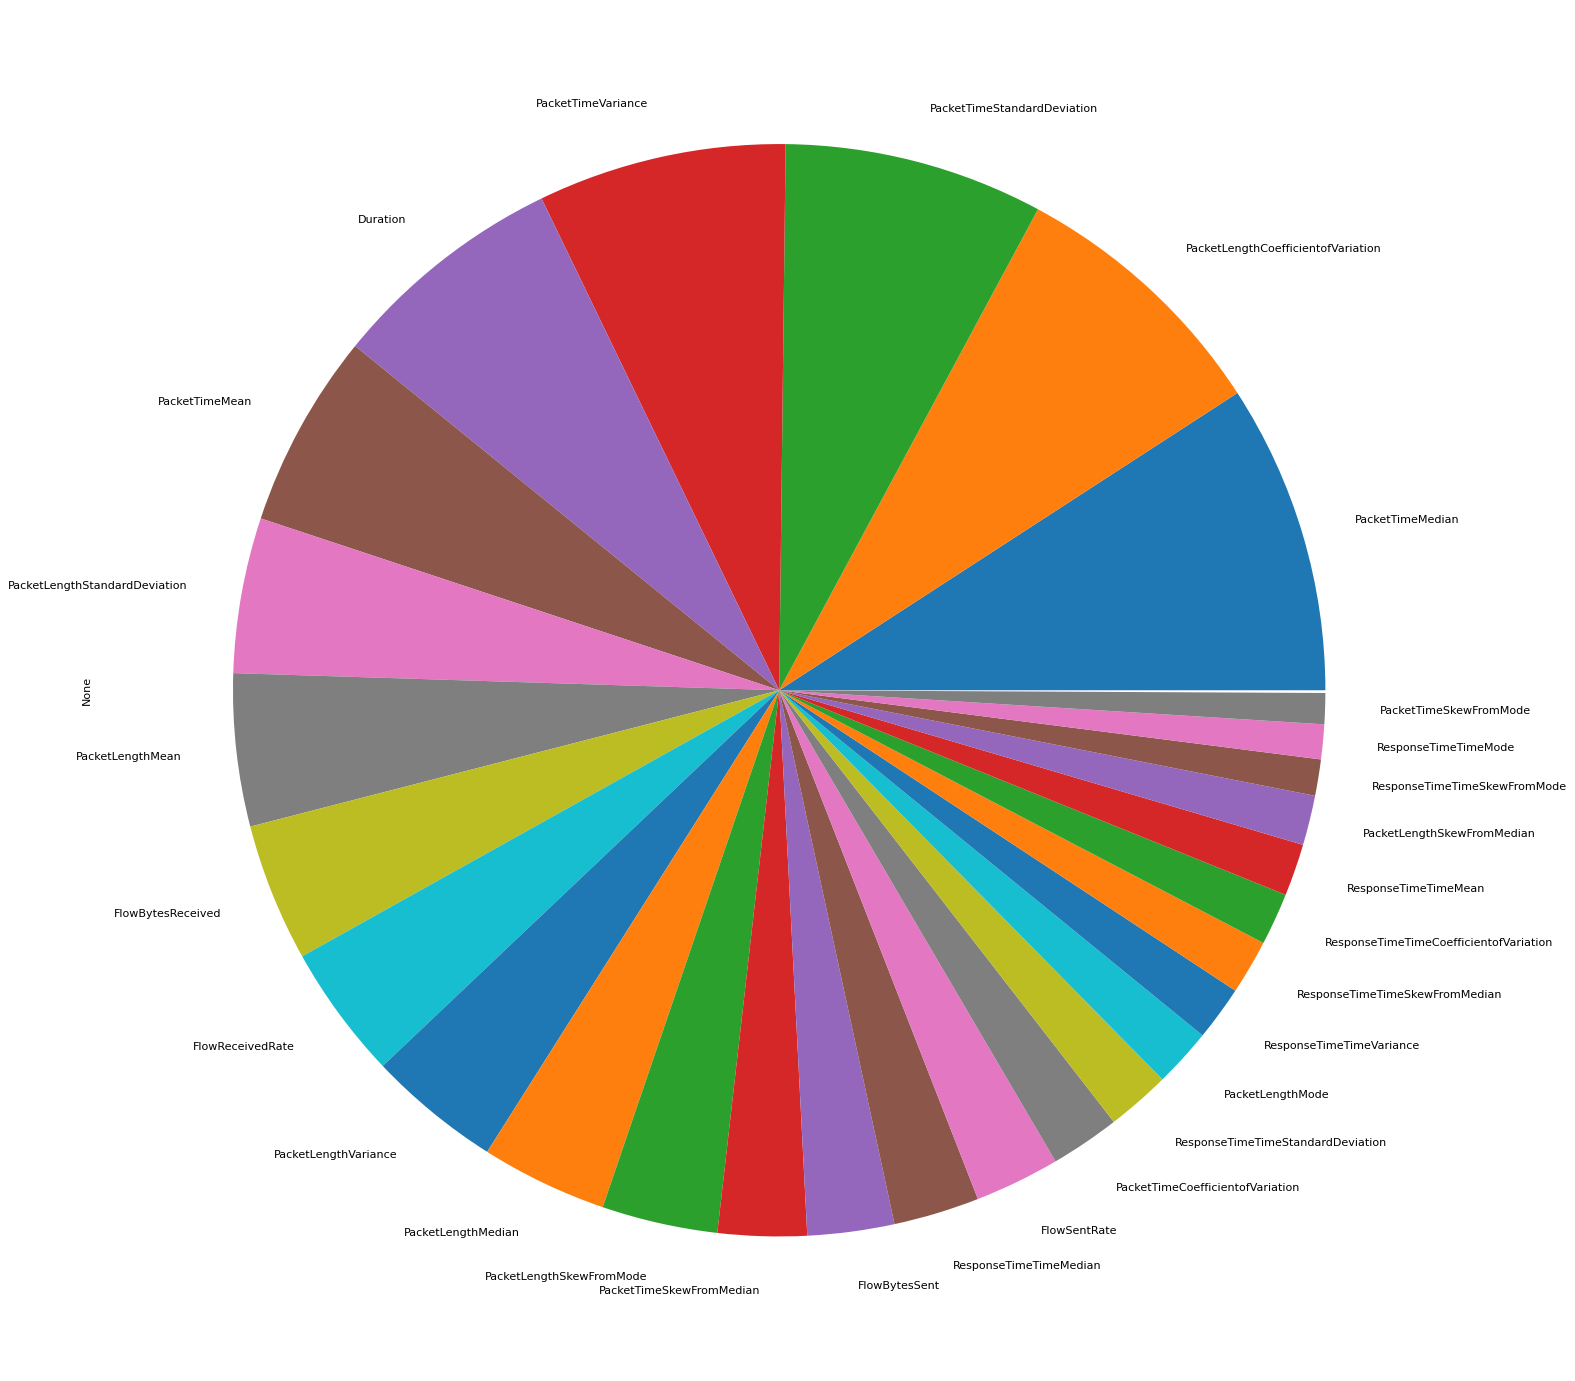

In [ ]:
# for feature selection
fig = plt.figure(num=None, figsize=(20, 22), dpi=80, facecolor='w', edgecolor='w')
feat_importances = pd.Series(clf.feature_importances_, index= X.columns).sort_values(ascending=True)
feat_importances.nlargest(28).plot(kind='pie')
#sns.barplot(y=feature_imp.index, x=feature_imp)

# Add labels to your graph
plt.xticks(rotation=45, horizontalalignment='left')
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()




RFC result 30% test set
0.9682709114440872
RFC accuracy test:
 0.9682709114440872

Confusion Matrix:
 [[49632   318   262]
 [  247 10000   632]
 [  216   703 12937]]

Classfication report:
               precision    recall  f1-score   support

     DNS2TCP       0.99      0.99      0.99     50212
     DNSCAT2       0.91      0.92      0.91     10879
      IODINE       0.94      0.93      0.93     13856

    accuracy                           0.97     74947
   macro avg       0.94      0.95      0.95     74947
weighted avg       0.97      0.97      0.97     74947

Validating Feature importance
[0.06845958 0.03242031 0.02886467 0.04462109 0.04874417 0.0354932
 0.04875109 0.04538802 0.04080334 0.01385375 0.01291233 0.02411055
 0.04113613 0.07211939 0.05624037 0.07475965 0.10029753 0.00052902
 0.03015126 0.00967566 0.02604158 0.01574893 0.01884484 0.01878671
 0.02911188 0.01208938 0.01887437 0.01421535 0.01695586]


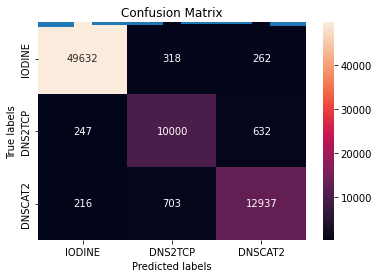

In [ ]:
print("RFC result 30% test set")
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(X_train_temp, y_train)
filename = 'finalized_RFC_model.sav'
joblib.dump(rfc, filename)
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test_temp, y_test)
print (result)

predictions_rfc = rfc.predict(X_test_temp)
print("RFC accuracy test:\n",accuracy_score(y_test, predictions_rfc))
print("\nConfusion Matrix:\n",confusion_matrix(y_test, predictions_rfc))
print("\nClassfication report:\n",classification_report(y_test, predictions_rfc))

from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt     
cf_matrix=confusion_matrix(y_test, predictions_rfc)
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['IODINE', 'DNS2TCP','DNSCAT2']); ax.yaxis.set_ticklabels(['IODINE', 'DNS2TCP','DNSCAT2']);
cf_matrix=confusion_matrix(y_test, predictions_rfc)

#import scikitplot as skplt #to make things easy
#y_pred_proba = rfc.predict_proba(X_test_temp)
#skplt.metrics.plot_roc(y_test, y_pred_proba)
#plt.show()

print ("Validating Feature importance")
# fit an Extra Trees model to the data
test_model = RandomForestClassifier()
test_model.fit(X_train_temp, y_train)
# display the relative importance of each attribute
print(test_model.feature_importances_)
# plot
plt.bar(range(len(test_model.feature_importances_)), test_model.feature_importances_)
plt.show()



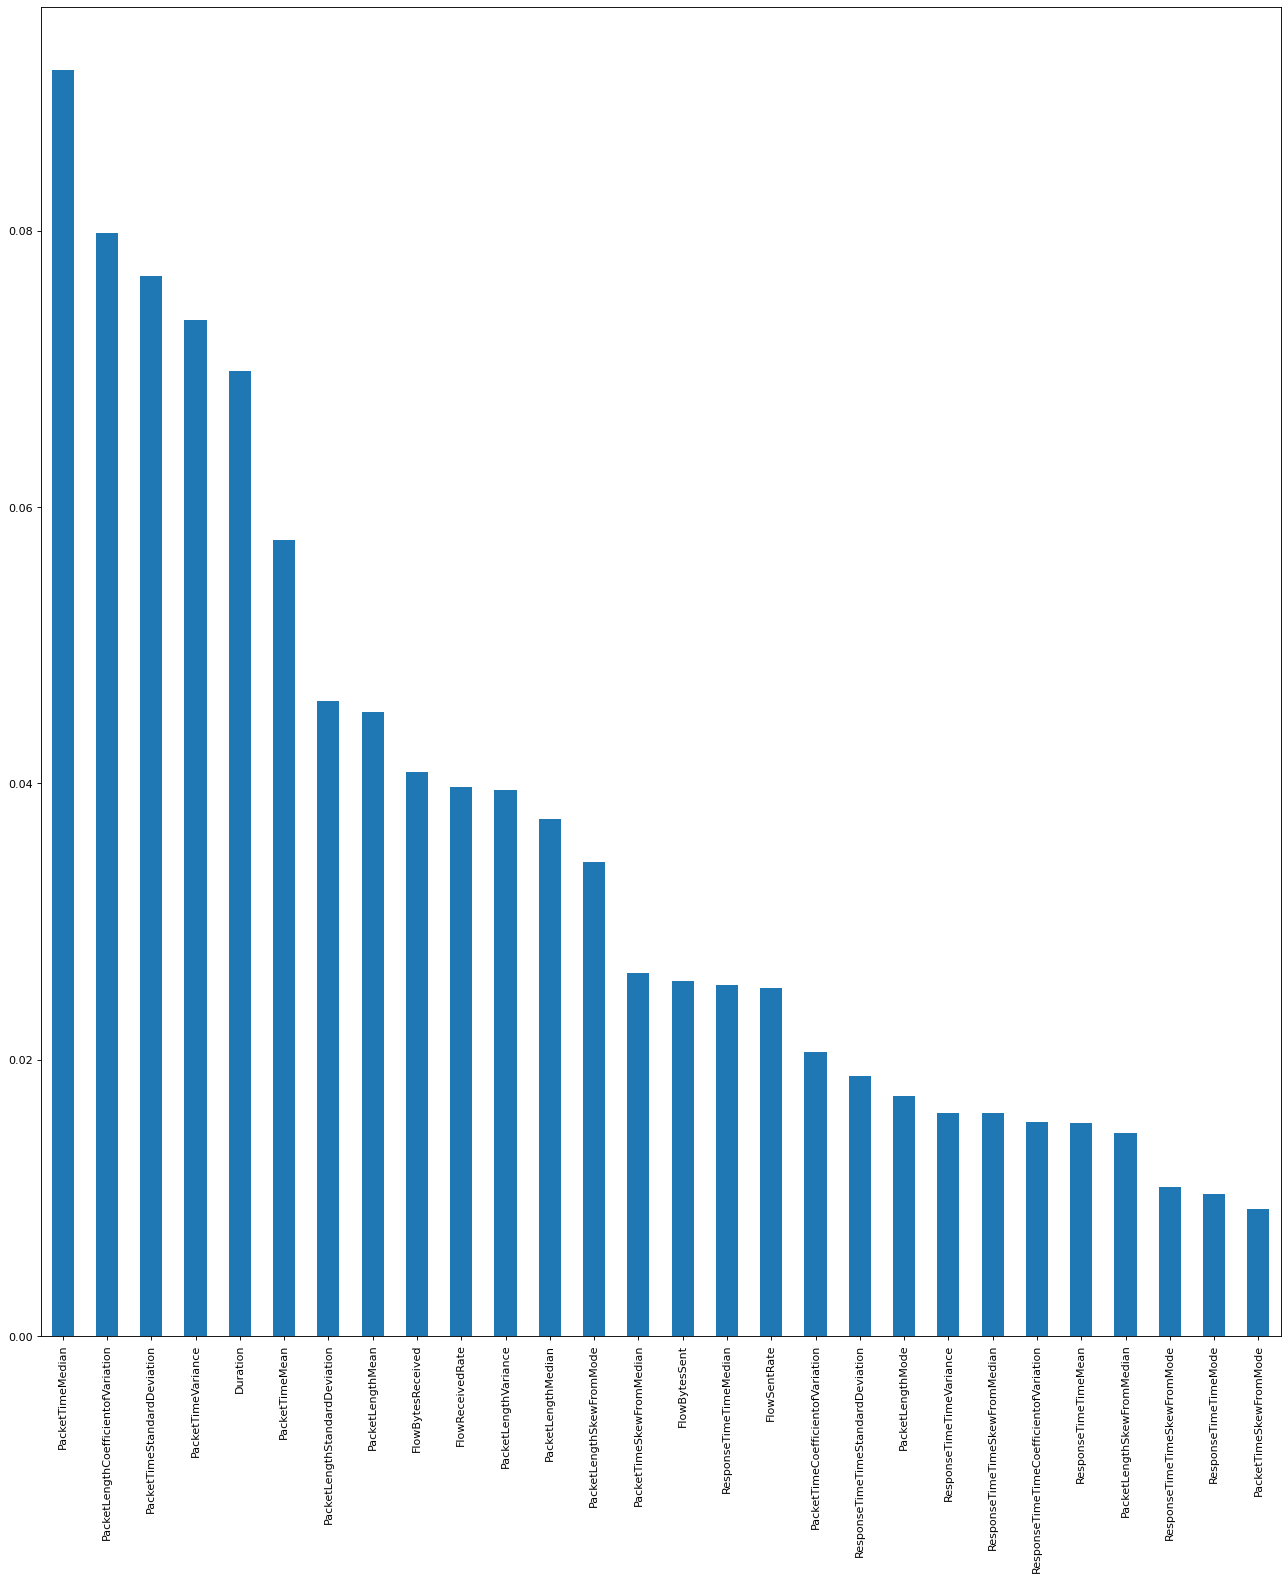

In [ ]:
# for feature selection
fig = plt.figure(num=None, figsize=(20, 22), dpi=80, facecolor='w', edgecolor='k')
feat_importances = pd.Series(clf.feature_importances_, index= X.columns).sort_values(ascending=True)
feat_importances.nlargest(28).plot(kind='bar')


